# Neptune + PyTorch

## Logging and Visualizing debugging metrics with Neptune

### Introduction

See how Neptune Scale can be used for pre-training models like foundation models by tracking hundreds of metrics. This example is designed to be used as a code recipe for you to re-use sections with your own code to edit to adapt to your own model training needs. 

This guide will show you how to:
- Initialize the Neptune Run object and log configuration parameters
- Log standard loss and accuracy metrics to Neptune
- Log debugging metrics during model training such as;
    * Activations per layer
    * Gradients (mean and std) per layer

### Install Dependencies and Import Libraries

In [ ]:
# Install dependencies
! pip install -q -U neptune_scale torch datasets

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
from datasets import load_dataset

import matplotlib.pyplot as plt

from neptune_scale import Run

c:\Users\leo.breedt\miniconda3\envs\neptune_scale_py_312_base\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize Parameters

In [2]:
# Initialize model, loss function, and optimizer

params = {
    "optimizer": "Adam",
    "batch_size": 3,
    "learning_rate": 0.001,
    "epochs": 5, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "input_features": 256,
    "embed_size": 1000,
    "hidden_size": 256, # hidden size for the LSTM
    "dropout_prob": 0.3,
    "num_lstm_layers": 3
}

## Download or use next token prediction dataset
The dataset used in this example is taken from [HuggingFace](https://huggingface.co/datasets/Na0s/Next_Token_Prediction_dataset). In this example, you can increase the size of the dataset to test the logging capabilities of Neptune, but note that increasing the dataset size will increase the time taken for the full dataset to download. The current setup only downloads the first 10 parquet files from the Hugging Face public dataset. 

In [10]:
# For the example, download a random subset of 10% of the original dataset
base_url = "https://huggingface.co/datasets/Na0s/Next_Token_Prediction_dataset/resolve/main/data/"
data_files = {"train": base_url + "train-00001-of-00067.parquet", # download only the first 10 files from the HF dataset
              "validation": base_url + "validation-00000-of-00001.parquet"} #doanload the complete validation dataset

data_subset = load_dataset("parquet", data_files = data_files, num_proc=4)
# validation_subset = load_dataset("parquet", data_files = {"validation": base_url + "validation-00000-of-00001.parquet"}, num_proc=4, split=["validation[:5%]"])
validation_subset = data_subset.get("validation").train_test_split(test_size=0.1)
print(data_subset)
print(validation_subset)

DatasetDict({
    train: Dataset({
        features: ['text', 'meta', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 81926
    })
    validation: Dataset({
        features: ['text', 'meta', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 9347
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'meta', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8412
    })
    test: Dataset({
        features: ['text', 'meta', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 935
    })
})


In [11]:
train_subset = data_subset["train"].with_format(type="torch", columns=["text", "input_ids", "labels"]) # HF provides methods to convert datatypes to tensors
validation_subset = validation_subset["test"].with_format(type="torch", columns=["text", "input_ids", "labels"]) # HF provides methods to convert datatypes to tensors

train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(validation_subset, batch_size=8, shuffle=True)

# Determine the vocab size of the dataset
# Flatten the list of tokenized sentences into one long list of token IDs
all_tokens = [token for sentence in data_subset["train"]["input_ids"] for token in sentence]

# Get unique token IDs
# unique_tokens = set(all_tokens)

# Vocab size is the number of unique tokens
vocab_size = max(all_tokens) + 1 # Add 1 since token ID's start from zero
params["vocab_size"] = vocab_size
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 128257


In [ ]:
# TODO - capture the folowings; attentions, learning rate (per layer if needed)
    # complete - activations, grad norms, gradients - weights+biases, loss - agg
# TODO - capture per layer losses
# TODO - increase number of layers
# TODO - Adding dropout to demonstrate the effects of regularization
# TODO - batch normalization
# TODO - add class for tracking activations, gradients, etc. automatically
# TODO - investigate packages that help with tracking layer-wise information
# TODO - visualize layer-wise information, activations, gradients etc. (use as example to share with product)
# TODO - update hooks for model, ensure tracking correct information

## Importance of Logging Debugging Metrics

During model training, capturing valuable information from each layer can offer critical insights into the model's learning process, identify potential issues, and guide improvements. Monitoring certain metrics and activations helps diagnose common problems such as vanishing gradients, overfitting, or underfitting. Below are key metrics to track from each layer:

### Key Metrics to Capture from Each Layer:

- **Activations**
  - **What it shows**: Provides insight into how the model is processing data. Dead or exploding activations can indicate issues with training stability.
  - **How to capture**: Use hooks to capture activations after each layer.

- **Gradients**
  - **What it shows**: Essential for diagnosing vanishing or exploding gradients. Small gradients may indicate vanishing gradients, while large ones can signal instability.
  - **How to capture**: Use hooks to capture gradients during backpropagation.

- **Weights and Biases**
  - **What it shows**: Tracks how the model’s parameters evolve during training. Large or small weights may indicate the need for better regularization or adjustments in learning rate.
  - **How to capture**: Extract directly from the model’s parameters.

- **Layer-wise Loss**
  - **What it shows**: Identifies which parts of the network contribute more to the overall loss, aiding debugging and optimization.
  - **How to capture**: Monitor outputs from each layer and compare with the target.

- **Learning Rate per Layer**
  - **What it shows**: Helpful if using techniques like Layer-wise Learning Rate Decay (L2LRD). Tracking this can provide insight into the layer-specific learning rate.
  - **How to capture**: Manually track based on optimizer settings.

- **Layer Output Norms**
  - **What it shows**: The L2-norm of layer outputs can highlight issues like gradient explosion or vanishing gradients.
  - **How to capture**: Compute the L2-norm for each layer’s output.

- **Activation Distributions**
  - **What it shows**: Helps diagnose saturation issues, especially with ReLU activations that may lead to dead neurons.
  - **How to capture**: Visualize or compute statistical summaries using tools like matplotlib or seaborn.

- **Feature Maps (for Convolutional Layers)**
  - **What it shows**: Offers insights into how convolutional layers detect specific patterns in the data.
  - **How to capture**: Visualize feature maps after convolutional layers using libraries like matplotlib.


### Define PyTorch Model Architecture and Helper functions
We define a simple LLM model architecture using PyTorch. Since this is a text-based example, we use a mebedding layer, an LSTM layer and a fully connected layer. This architecture can be adjusted to your needs and increased in size when testing the workflow.

In [ ]:
# Define the simple LLM model with LSTM
class SimpleLLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SimpleLLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, 512, num_layers = num_layers, dropout = 0.3, batch_first=True)
        self.fc1 = nn.Linear(512, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

        # Initialize activations dictionary to store layer activations
        self.activations = {}

        ## Registering hooks to track activations
        self.hooks = []
        self.hooks.append(self.lstm.register_forward_hook(self.save_activation("lstm")))
        self.hooks.append(self.fc1.register_forward_hook(self.save_activation("fc1")))
        self.hooks.append(self.fc2.register_forward_hook(self.save_activation("fc2")))

        ## Registering hooks to track gradients
        #self.hooks.append(self.lstm.register_full_backward_hook(self.save_gradient("lstm")))
        #self.hooks.append(self.fc1.register_full_backward_hook(self.save_gradient("fc1")))
        #self.hooks.append(self.fc2.register_full_backward_hook(self.save_gradient("fc2")))
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)  # LSTM returns output and hidden/cell state tuple
        out = self.fc1(lstm_out) # Use the last output from the LSTM
        out = self.fc2(out)
        return out
    
    # Function to save activations
    def save_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output
        return hook
    
    def get_activations(self):
        return self.activations

    def clear_activations(self):
        self.activations = {}

    # Function to save gradients TODO: check where gradients should be calculated
    def save_gradient(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]  # Save gradient output in the dictionary
        return hook
    
    def get_gradients(self):
        return self.gradients
    
    def clear_gradients(self):
        self.gradients = {}

# Function to evaluate the model after each epoch/step
def evaluate(model, val_dataloader, criterion, device, vocab_size):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass for validation
            logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
            
            # Calculate the loss
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    return avg_val_loss

In [25]:
# Define the simple LLM model with LSTM
class SimpleLLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SimpleLLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, 512, num_layers = num_layers, dropout = 0.3, batch_first=True)
        self.fc1 = nn.Linear(512, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)  # LSTM returns output and hidden/cell state tuple
        out = self.fc1(lstm_out) # Use the last output from the LSTM
        out = self.fc2(out)
        return out
    
# model = SimpleLLM(params["vocab_size"], params["embed_size"], params["hidden_size"], params["num_lstm_layers"])

# A class to manage hooks for activations and gradients
class HookManager:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.activations = {}
        self.gradients = {}

    # Function to save activations
    def save_activation(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    # Function to save gradients (registering hooks for the model parameters)
    def save_gradient(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]
        return hook

    # Function to register hooks for activations and gradients
    def register_hooks(self):
        # Register forward hooks for activations
        for name, module in self.model.named_modules():
            self.hooks.append(module.register_forward_hook(self.save_activation(name)))

        # Register backward hooks for gradients
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.LSTM, nn.Linear)): # You can add more layer types here
                self.hooks.append(module.register_full_backward_hook(self.save_gradient(name)))

    # Function to clear activations and gradients after use
    def clear(self):
        self.activations = {}
        self.gradients = {}

    # Function to get activations
    def get_activations(self):
        return self.activations

    # Function to get gradients
    def get_gradients(self):
        return self.gradients

# Function to evaluate the model after each epoch/step
def evaluate(model, val_dataloader, criterion, device, vocab_size):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass for validation
            logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
            
            # Calculate the loss
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    return avg_val_loss

Everytime a new LSTM layer is added when updating the `num_lstm_layers` parameter is changed, 12 new metrics will be logged which correspond to mean, std and norm that are calculated. 

In [31]:
# Define Neptune parameters
from neptune_scale import Run
from uuid import uuid4

run = Run(
    project = "leo/pytorch-tutorial",
    run_id=f"pytorch-text-{uuid4()}"
    )

run.log_configs(
    {
        "config/learning_rate": params["learning_rate"],
        "config/optimizer": params["optimizer"],
        "config/batch_size": params["batch_size"],
        "config/epochs": params["epochs"],
        "config/num_lstm_layers" : params["num_lstm_layers"],
        # "data/vocab_size": params["vocab_size"],
        "data/embed_size": params["embed_size"]
    }
)

run.add_tags(tags=[params["optimizer"]], group_tags=True)
run.add_tags(tags=["text", "LLM", "Simple"])

In [ ]:
debug_metrics = {}

# Initialize model and optimizer
model = SimpleLLM(params["vocab_size"], params["embed_size"], params["hidden_size"], params["num_lstm_layers"])
optimizer = optim.Adam(model.parameters(), lr = params["learning_rate"])
criterion = nn.CrossEntropyLoss(ignore_index=-100) # Ignore the buffering index of -100 in the dataset

hook_manager = HookManager(model)
hook_manager.register_hooks()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
step_counter = 0

# Training loop
for epoch in range(params["epochs"]):
    total_loss = 0
    for batch in train_dataloader:
        model.train()
        step_counter += 1
        hook_manager.clear()

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids)
        
        # Compute the loss (ignore padding tokens by masking labels)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()
        print(f"Step {step_counter} / {len(train_dataloader)}, Loss: {loss.item()}")

        if step_counter % 5 == 0: # Do not need to log validation at every step, although we can
            val_loss = evaluate(model, val_dataloader, criterion, device, vocab_size)
            print(f"Step {step_counter}, Val_loss: {val_loss}")

            # Track activations
            activations = hook_manager.get_activations()
            for layer, activation in activations.items():
                print(f"Activations for {layer}: {activation[0].mean().item()}")
                debug_metrics[f"layers/layer_{layer}/activation_mean"] = activation[0].mean().item()
                debug_metrics[f"layers/layer_{layer}/activation_std"] = activation[0].std().item()

            # Track gradients with hooks
            gradients = hook_manager.get_gradients()
            for layer, gradient in gradients.items():
               debug_metrics[f"grad_hooks/{layer}"] = gradient.mean().item()
               print(f"Gradients for {layer}: {gradient.mean().item()}") # You can replace to use mean(), sum(), max() or min()
               # simplified_gradient = gradient.mean(dim=(0, 1))
               # print(f"Summed Gradient for {layer}: {simplified_gradient}")

            # Track gradients per layer at each epoch
            for name, param in model.named_parameters():
                if param is not None:
                    debug_metrics[f"layers/layer_{name}_std"] = param.grad.std().item()
                    debug_metrics[f"layers/layer_{name}_mean"] = param.grad.mean().item()
                    debug_metrics[f"layers/layer_{name}_norm"] = param.grad.norm().item() # L2 norm (Euclidean norm) of the gradients

            # Output loss for this epoch
            run.log_metrics(
                data = {
                    "metrics/train/loss": loss.item(),
                    "metrics/validation/loss": val_loss,
                    "epoch/value": epoch,
                    **debug_metrics
                },
                step = step_counter
            )
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# test_loss = evaluate_model(model, test_input, test_target, params["vocab_size"])
# print(f'Test Loss: {test_loss:.4f}')


In [33]:

run.close()

neptune:INFO: Waiting for all operations to be processed
neptune:WARNING: No timeout specified. Waiting indefinitely
neptune:INFO: All operations were processed


In [ ]:

# After training, you can analyze the activations and gradients
# Example: Plot the activations of the LSTM layer
layer_name, activation = activations[0]  # Assuming lstm activation
print(f"Activation for {layer_name} layer: ", activation)

# Plotting histogram of activations of the LSTM layer
plt.hist(activation[0].detach().numpy().flatten(), bins=100, alpha=0.7, color='b', label='LSTM Activations')
plt.title(f"Activation Distribution for {layer_name}")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example: Plot the gradients of the LSTM layer
layer_name, grad = gradients[0]  # Assuming lstm gradient
print(f"Gradient for {layer_name} layer: ", grad[0].shape)

# Plotting histogram of gradients of the LSTM layer
plt.hist(grad[0].numpy().flatten(), bins=100, alpha=0.7, color='r', label='LSTM Gradients')
plt.title(f"Gradient Distribution for {layer_name}")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


KeyError: 0

Activation for fc layer:  torch.Size([3, 5, 5000])


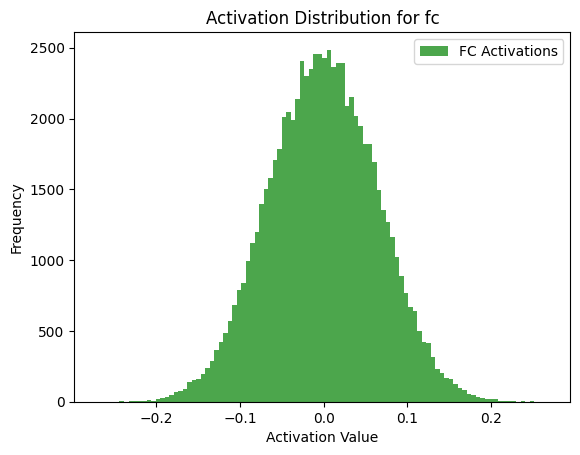

Gradient for lstm layer:  torch.Size([3, 5, 256])


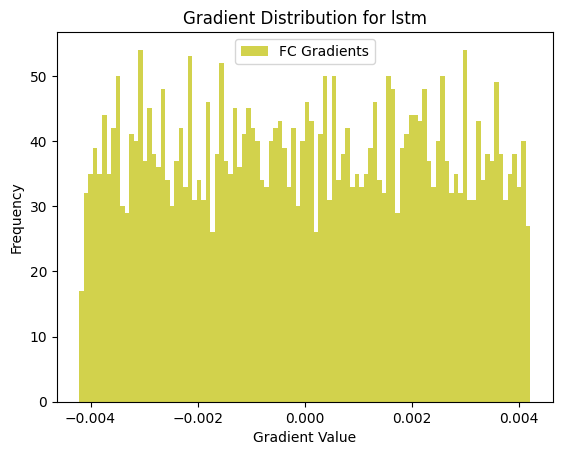

In [17]:

# Example: Plot the activations of the final Linear layer
layer_name, activation = activations[1]  # Assuming fc activation
print(f"Activation for {layer_name} layer: ", activation.shape)

# Plotting histogram of activations of the final Linear layer
plt.hist(activation.detach().numpy().flatten(), bins=100, alpha=0.7, color='g', label='FC Activations')
plt.title(f"Activation Distribution for {layer_name}")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example: Plot the gradients of the final Linear layer
layer_name, grad = gradients[1]  # Assuming fc gradient
print(f"Gradient for {layer_name} layer: ", grad[0].shape)

# Plotting histogram of gradients of the final Linear layer
plt.hist(grad[0].numpy().flatten(), bins=100, alpha=0.7, color='y', label='FC Gradients')
plt.title(f"Gradient Distribution for {layer_name}")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
